In [1]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal,Annotated
from pydantic import BaseModel,Field
from langchain_core.prompts import PromptTemplate,ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser
from dotenv import load_dotenv
import operator

In [2]:
load_dotenv()

model = ChatOpenAI()

parser = StrOutputParser()

In [3]:
class TweetState(TypedDict):

    topic : str
    tweet : str
    evaluation : Literal['approved','needs_improvement']
    feedback : str
    iteration : int
    max_iteration : int

    tweet_history = Annotated[list[str],operator.add]
    feedback_history = Annotated[list[str],operator.add]

In [29]:
class TweetEvaluation(BaseModel):

    evaluation : Literal["approved", "needs_improvement"] = Field(required = True,description = 'Final evaluation result.')
    feedback : str = Field(required = True,description = 'feedback for the tweet.')

parser1 = PydanticOutputParser(pydantic_object = TweetEvaluation)

In [42]:
def generate_tweet(state:TweetState)->dict:

    topic = state['topic']

    template = ChatPromptTemplate([
        ('system','You are a funny and clever Twitter/X influencer.'),
        ('human',"""
        Write a short, original, and hilarious tweet on the topic: "{topic}".

        Rules:
        - Do NOT use question-answer format.
        - Max 280 characters.
        - Use observational humor, irony, sarcasm, or cultural references.
        - Think in meme logic, punchlines, or relatable takes.
        - Use simple, day to day english
        """)
    ])

    chain = template | model | parser

    response = chain.invoke({'topic':topic})

    return {'tweet' : response}

def evaluate(state : TweetState)->dict:

    topic = state['topic']
    tweet = state['tweet']

    template = ChatPromptTemplate.from_messages([
        ('system','You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format.'
                    "Return ONLY valid JSON. Do NOT return the schema."),
        ('human',"""
    Evaluate the following tweet:

    Tweet: "{tweet}"

    Use the criteria below to evaluate the tweet:

    1. Originality – Is this fresh, or have you seen it a hundred times before?  
    2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
    3. Punchiness – Is it short, sharp, and scroll-stopping?  
    4. Virality Potential – Would people retweet or share it?  
    5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

    Auto-reject if:
    - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
    - It exceeds 280 characters
    - It reads like a traditional setup-punchline joke
    - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)
    \n {format_instruction}
    """)
    ])

    chain = template | model | parser1

    response = chain.invoke({'tweet':tweet,'format_instruction':parser1.get_format_instructions()})

    # print(response)

    return {'evaluation':response.evaluation,'feedback':response.feedback,'feedback_history':[response.feedback]}


def route_evaluation(state:TweetState)->dict:

    evaluation = state['evaluation']
    max_iteration = state['max_iteration']
    iteration = state['iteration']

    if evaluation == 'approved' or iteration >= max_iteration :
        return 'approved'
    else:
        return 'needs_improvement'    

def optimize(state:TweetState)->dict:

    topic = state['topic']
    tweet = state['tweet']

    template = ChatPromptTemplate([
        ('system','You punch up tweets for virality and humor based on given feedback.'),
        ('human',"""
        Improve the tweet based on this feedback:
        "{state['feedback']}"

        Topic: "{topic}"
        Original Tweet:
        {tweet}

        Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
        """)
    ])

    iteration = state['iteration'] + 1

    chain = template | model | parser

    response = chain.invoke({'topic':topic,'tweet':tweet})

    return {'iteration':iteration,'tweet':response,'tweet_history':[response]}


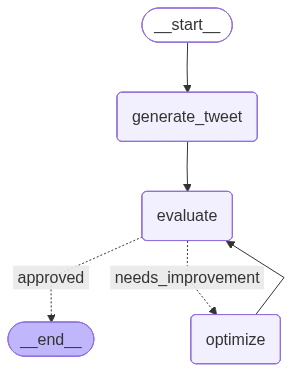

In [34]:
graph = StateGraph(TweetState)

graph.add_node('generate_tweet',generate_tweet)
graph.add_node('evaluate',evaluate)
graph.add_node('optimize',optimize)

graph.add_edge(START,'generate_tweet')
graph.add_edge('generate_tweet','evaluate')

graph.add_conditional_edges('evaluate',route_evaluation,{
    'approved':END,
    'needs_improvement' : 'optimize'
})
graph.add_edge('optimize','evaluate')

workflow = graph.compile()

workflow

In [41]:
initial_state = {
    'topic' : 'asdfADHvgvgvgvgcb ZXVcZHjasdbcszdv',
    'iteration':1,
    'max_iteration':5
}

final_state = workflow.invoke(initial_state)

final_state

evaluation='approved' feedback="This tweet scores high in originality as it combines a common typing mistake with summoning a demon, creating a fresh and amusing scenario. The humor is evident in the unexpected outcome and the requirement for a roommate who loves 'long walks in hell'. The tweet is concise, engaging, and likely to pique interest due to its quirky nature. The format is well-suited for Twitter, and the inclusion of relevant hashtags enhances its virality potential."


{'topic': 'asdfADHvgvgvgvgcb ZXVcZHjasdbcszdv',
 'tweet': 'Just tried typing random letters on my keyboard and accidentally summoned a demon. Now accepting applications for a new roommate. Must love long walks in hell. #TypoTroubles #SendHelp',
 'evaluation': 'approved',
 'feedback': "This tweet scores high in originality as it combines a common typing mistake with summoning a demon, creating a fresh and amusing scenario. The humor is evident in the unexpected outcome and the requirement for a roommate who loves 'long walks in hell'. The tweet is concise, engaging, and likely to pique interest due to its quirky nature. The format is well-suited for Twitter, and the inclusion of relevant hashtags enhances its virality potential.",
 'iteration': 1,
 'max_iteration': 5}